In [15]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from dataset_eff import DatasetPrepare_ETD
import torch
from torchvision import transforms
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCAß
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

In [20]:
seed = 199
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda")

In [21]:
import numpy as np

def _worker_init_fn(worker_id):
    # mỗi worker có seed khác nhau để augment ngẫu nhiên ổn định
    seed = 199 + worker_id
    np.random.seed(seed)
    torch.manual_seed(seed)

In [22]:
root_dir = "../data/ksm_transformer_best_result"
batch_size = 64
window_size = 37
num_workers = 4
d_model = 64
max_time_position = 64
log_e = 2

# 1-channel stats
mean = (0.5,)
std  = (0.5,)

# --- transforms ---
test_transform = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
])

# --- datasets ---
test_dataset = DatasetPrepare_ETD(
    root_dir=root_dir,
    sequence_size=window_size,
    pad_size=0,
    embed=d_model,
    max_time_position=max_time_position,
    log_e=log_e,
    transform=test_transform,          # single-view
    is_train=False,
    do_instance_norm=True,
    target_size=(64, 64),
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=num_workers,
    worker_init_fn=_worker_init_fn,
    persistent_workers=(num_workers > 0),
)

In [23]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [24]:
from networks.efficient_net import ConEfficientNet, LinearClassifier

model = ConEfficientNet(embedding_dim=1792, feat_dim=128, head='mlp', pretrained=False)
classifier = LinearClassifier(input_dim=128, num_classes=2)

In [25]:
# /home/hieutt/electricity_theft_detection/save/UniCon_ETD
save_path = '../save/UniCon_ETD'
ckpt_epoch = 266

model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [26]:
class_model_path = f'{save_path}/ckpt_class_epoch_{ckpt_epoch}.pth'

ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [30]:
import numpy as np
import tqdm
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
total_embs = np.empty(shape=(0, 128), dtype=float)
# total_embs = np.empty(shape=(0, 2048), dtype=float)

model = model.cuda()
classifier = classifier.cuda()
model.eval()
classifier.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.cuda(non_blocking=True)
        embs = model(images)
        outputs = classifier(embs)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()

        total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)
# After the loop, total_pred, total_label, and total_embs will have accumulated data


100%|██████████| 183/183 [00:04<00:00, 41.44it/s]


In [33]:
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    cm = confusion_matrix(label, pred)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision[np.isnan(precision)] = 0  # Handle NaN values in precision
    
    f1 = 2 * recall * precision / (recall + precision)
    f1[np.isnan(f1)] = 0  # Handle NaN values in F1 score
    
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    fnr = (total_actual - true_predicted) * 100 / total_actual
    
    return cm, {
        'fnr': np.array(fnr),
        'rec': recall,
        'pre': precision,
        'f1': f1
    }

In [32]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (8 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [31]:
classes = ['Normal', 'Theft']
colors = ['#1f77b4', '#ff7f0e']

n_classes = len(classes)

In [34]:
cm, results = cal_metric(total_label, total_pred)
print_metrics_horizontal(results, classes)

Metric | Normal   | Theft   
----------------------------
FNR    | 0.2060   | 1.2853  
REC    | 0.9979   | 0.9871  
PRE    | 0.9873   | 0.9979  
F1     | 0.9926   | 0.9925  


In [36]:
from sklearn.metrics import classification_report


report = classification_report(total_label, total_pred, target_names=classes, digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Normal     0.9873    0.9979    0.9926      5825
       Theft     0.9979    0.9871    0.9925      5835

    accuracy                         0.9925     11660
   macro avg     0.9926    0.9925    0.9925     11660
weighted avg     0.9926    0.9925    0.9925     11660



100%|██████████| 183/183 [00:05<00:00, 30.60it/s]


ROC AUC (binary): 0.9915


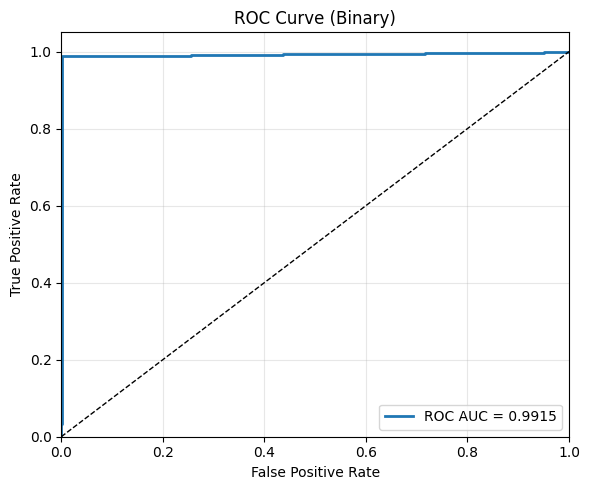

In [37]:
import numpy as np
import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ===== Collect logits/probs, labels =====
all_probs  = []
all_labels = []

model = model.cuda().eval()
classifier = classifier.cuda().eval()

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        embs   = model(images)             # [B, latent_dim]
        logits = classifier(embs)          # [B, 2]  (binary: 2 classes)
        probs  = F.softmax(logits, dim=1)  # [B, 2]

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack to numpy
all_probs  = np.concatenate(all_probs,  axis=0)   # (N, 2)
all_labels = np.concatenate(all_labels, axis=0)   # (N,)

# ===== Compute ROC AUC =====
y_score = all_probs[:, 1]   # prob cho class=1 (positive)
auc_val = roc_auc_score(all_labels, y_score)
print(f'ROC AUC (binary): {auc_val:.4f}')

# ===== Plot ROC curve =====
fpr, tpr, _ = roc_curve(all_labels, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='C0', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Binary)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
